# 🏙️ Miasto 15-minutowe - Agregacja wg Jednostek Urbanistycznych

Analiza dostępności usług zagregowana do **111 jednostek urbanistycznych** Krakowa.

---

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

CRS_METRIC = "EPSG:2180"
print("✅ Biblioteki załadowane")

✅ Biblioteki załadowane


## 1. Wczytanie Jednostek Urbanistycznych

In [2]:
# Wczytaj dane transakcji (zawierają geometrię jednostek)
print("📂 Wczytywanie jednostek urbanistycznych...")

gdf1 = gpd.read_file('data/raw/transactions_pierwotny_2023_2025_clean.geojson')
gdf2 = gpd.read_file('data/raw/transactions_wtorny_2023_2025_clean.geojson')

# Połącz oba zbiory
gdf_all = pd.concat([gdf1, gdf2], ignore_index=True)
gdf_all = gpd.GeoDataFrame(gdf_all, geometry='geometry', crs=gdf1.crs)

# Wyodrębnij unikalne jednostki (dissolve by name)
units_gdf = gdf_all.dissolve(by='nazwa_jedn').reset_index()
units_gdf = units_gdf[['nazwa_jedn', 'geometry']]
units_gdf = units_gdf.to_crs(CRS_METRIC)

print(f"✅ Wczytano {len(units_gdf)} jednostek urbanistycznych")
print(f"\nPrzykładowe nazwy:")
for name in units_gdf['nazwa_jedn'].head(10):
    print(f"   • {name}")

📂 Wczytywanie jednostek urbanistycznych...
✅ Wczytano 111 jednostek urbanistycznych

Przykładowe nazwy:
   • Azory Wschód
   • Azory Zachód
   • Batowice
   • Beszcz
   • Bieńczyce Nowe
   • Bieńczyce Stare
   • Bieżanów Kolonia
   • Bonarka
   • Borek Fałęcki Wschód
   • Borek Fałęcki Zachód


## 2. Wczytanie Wyników Analizy 15-minutowej

In [3]:
# Wczytaj siatkę z wynikami
print("📂 Wczytywanie wyników analizy 15-minutowej...")

grid_gdf = gpd.read_file('data/miasto_15_min_wyniki.gpkg', layer='accessibility_grid')
grid_gdf = grid_gdf.to_crs(CRS_METRIC)

print(f"✅ Wczytano {len(grid_gdf):,} punktów siatki")
print(f"\nRozkład Compliance Score:")
for score in range(6):
    count = (grid_gdf['compliance_score'] == score).sum()
    pct = count / len(grid_gdf) * 100
    print(f"   Score {score}: {count:,} ({pct:.1f}%)")

📂 Wczytywanie wyników analizy 15-minutowej...
✅ Wczytano 5,222 punktów siatki

Rozkład Compliance Score:
   Score 0: 191 (3.7%)
   Score 1: 385 (7.4%)
   Score 2: 753 (14.4%)
   Score 3: 730 (14.0%)
   Score 4: 858 (16.4%)
   Score 5: 2,305 (44.1%)


## 3. Spatial Join - Przypisanie Punktów do Jednostek

In [4]:
# Spatial join - przypisz każdy punkt siatki do jednostki
print("🔗 Spatial join: przypisywanie punktów do jednostek...")

grid_with_units = gpd.sjoin(
    grid_gdf, 
    units_gdf, 
    how='left', 
    predicate='within'
)

# Sprawdź ile punktów przypisano
assigned = grid_with_units['nazwa_jedn'].notna().sum()
print(f"✅ Przypisano {assigned:,} / {len(grid_gdf):,} punktów ({assigned/len(grid_gdf)*100:.1f}%)")

# Punkty poza jednostkami (np. na granicy)
unassigned = len(grid_gdf) - assigned
if unassigned > 0:
    print(f"⚠️  {unassigned:,} punktów poza jednostkami (na granicy miasta)")

🔗 Spatial join: przypisywanie punktów do jednostek...
✅ Przypisano 3,441 / 5,222 punktów (65.9%)
⚠️  1,781 punktów poza jednostkami (na granicy miasta)


## 4. Agregacja - % Punktów z Pełnym Pokryciem

In [5]:
# Dla każdej jednostki oblicz % punktów z compliance_score = 5
print("📊 Obliczanie wskaźnika pokrycia dla jednostek...")

# Filtruj tylko przypisane punkty
grid_assigned = grid_with_units[grid_with_units['nazwa_jedn'].notna()].copy()

# Agregacja per jednostka
aggregation = grid_assigned.groupby('nazwa_jedn').agg(
    total_points=('compliance_score', 'count'),
    full_coverage_points=('compliance_score', lambda x: (x == 5).sum()),
    avg_score=('compliance_score', 'mean')
).reset_index()

# Oblicz procent pełnego pokrycia
aggregation['full_coverage_pct'] = (aggregation['full_coverage_points'] / aggregation['total_points'] * 100).round(1)

# Połącz z geometrią
units_results = units_gdf.merge(aggregation, on='nazwa_jedn', how='left')

# Uzupełnij brakujące wartości (jednostki bez punktów)
units_results['full_coverage_pct'] = units_results['full_coverage_pct'].fillna(0)
units_results['avg_score'] = units_results['avg_score'].fillna(0)
units_results['total_points'] = units_results['total_points'].fillna(0).astype(int)

print(f"✅ Obliczono wskaźniki dla {len(units_results)} jednostek")

# Podsumowanie
print(f"\n📈 Statystyki:")
print(f"   Średni % pełnego pokrycia: {units_results['full_coverage_pct'].mean():.1f}%")
print(f"   Mediana: {units_results['full_coverage_pct'].median():.1f}%")
print(f"   Min: {units_results['full_coverage_pct'].min():.1f}%")
print(f"   Max: {units_results['full_coverage_pct'].max():.1f}%")

📊 Obliczanie wskaźnika pokrycia dla jednostek...
✅ Obliczono wskaźniki dla 111 jednostek

📈 Statystyki:
   Średni % pełnego pokrycia: 78.8%
   Mediana: 96.9%
   Min: 0.0%
   Max: 100.0%


In [6]:
# Tabela ranking jednostek
print("🏆 TOP 10 - Najlepsze jednostki (% pełnego pokrycia):")
print("="*60)
top10 = units_results.nlargest(10, 'full_coverage_pct')[['nazwa_jedn', 'full_coverage_pct', 'avg_score', 'total_points']]
for i, row in enumerate(top10.itertuples(), 1):
    print(f"{i:2}. {row.nazwa_jedn:30} | {row.full_coverage_pct:5.1f}% | śr: {row.avg_score:.2f}")

print(f"\n❌ BOTTOM 10 - Najsłabsze jednostki:")
print("="*60)
bottom10 = units_results[units_results['total_points'] > 0].nsmallest(10, 'full_coverage_pct')[['nazwa_jedn', 'full_coverage_pct', 'avg_score', 'total_points']]
for i, row in enumerate(bottom10.itertuples(), 1):
    print(f"{i:2}. {row.nazwa_jedn:30} | {row.full_coverage_pct:5.1f}% | śr: {row.avg_score:.2f}")

🏆 TOP 10 - Najlepsze jednostki (% pełnego pokrycia):
 1. Azory Wschód                   | 100.0% | śr: 5.00
 2. Azory Zachód                   | 100.0% | śr: 5.00
 3. Bieńczyce Nowe                 | 100.0% | śr: 5.00
 4. Bonarka                        | 100.0% | śr: 5.00
 5. Borek Fałęcki Zachód           | 100.0% | śr: 5.00
 6. Bronowice Małe Wschód          | 100.0% | śr: 5.00
 7. Cegielniana                    | 100.0% | śr: 5.00
 8. Centrum A - Hutnicze Ogrodowe  | 100.0% | śr: 5.00
 9. Centrum B - Szklane Domy       | 100.0% | śr: 5.00
10. Centrum C - Zgody              | 100.0% | śr: 5.00

❌ BOTTOM 10 - Najsłabsze jednostki:
 1. Branice                        |   0.0% | śr: 2.84
 2. Lubocza                        |   0.0% | śr: 2.98
 3. Olszyny                        |   0.0% | śr: 2.79
 4. Olszanica                      |   1.0% | śr: 2.45
 5. Kosocice                       |   1.2% | śr: 2.44
 6. Opatkowice Wschód              |   3.3% | śr: 3.07
 7. Sidzina                   

## 5. Mapa - % Pełnego Pokrycia wg Jednostek

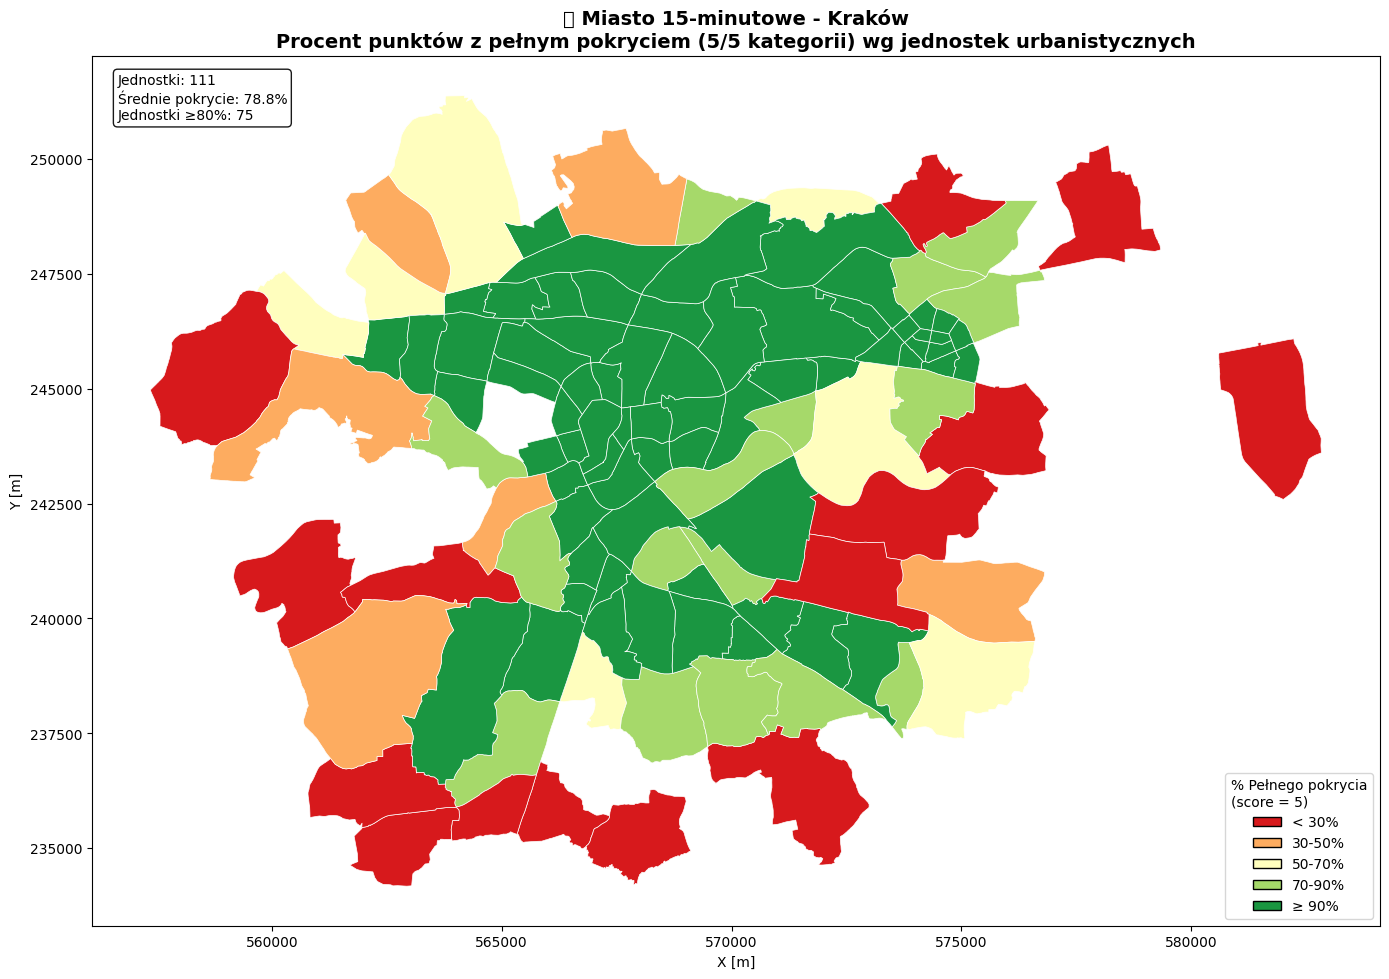

💾 Zapisano: data/mapa_jednostki_pokrycie.png


In [7]:
# Kolorystyka: czerwony -> żółty -> zielony
colors = ['#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641']
cmap = LinearSegmentedColormap.from_list('coverage', colors)

# Progi: <30%, 30-50%, 50-70%, 70-90%, >90%
bounds = [0, 30, 50, 70, 90, 100]
norm = BoundaryNorm(bounds, cmap.N)

# Mapa
fig, ax = plt.subplots(figsize=(14, 12))

# Rysuj jednostki
units_results.plot(
    ax=ax,
    column='full_coverage_pct',
    cmap=cmap,
    norm=norm,
    edgecolor='white',
    linewidth=0.5,
    legend=False
)

# Legenda
legend_labels = ['< 30%', '30-50%', '50-70%', '70-90%', '≥ 90%']
legend_colors = [cmap(norm(15)), cmap(norm(40)), cmap(norm(60)), cmap(norm(80)), cmap(norm(95))]
legend_elements = [mpatches.Patch(facecolor=c, edgecolor='black', label=l) 
                   for c, l in zip(legend_colors, legend_labels)]
ax.legend(handles=legend_elements, loc='lower right', title='% Pełnego pokrycia\n(score = 5)', fontsize=10)

# Tytuł
ax.set_title(
    '🏙️ Miasto 15-minutowe - Kraków\n'
    'Procent punktów z pełnym pokryciem (5/5 kategorii) wg jednostek urbanistycznych',
    fontsize=14, fontweight='bold'
)

# Statystyki
units_above_80 = (units_results['full_coverage_pct'] >= 80).sum()
stats_text = (
    f"Jednostki: {len(units_results)}\n"
    f"Średnie pokrycie: {units_results['full_coverage_pct'].mean():.1f}%\n"
    f"Jednostki ≥80%: {units_above_80}"
)
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

ax.set_aspect('equal')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')

plt.tight_layout()
plt.savefig('data/mapa_jednostki_pokrycie.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Zapisano: data/mapa_jednostki_pokrycie.png")

## 6. Mapa ze średnim Compliance Score

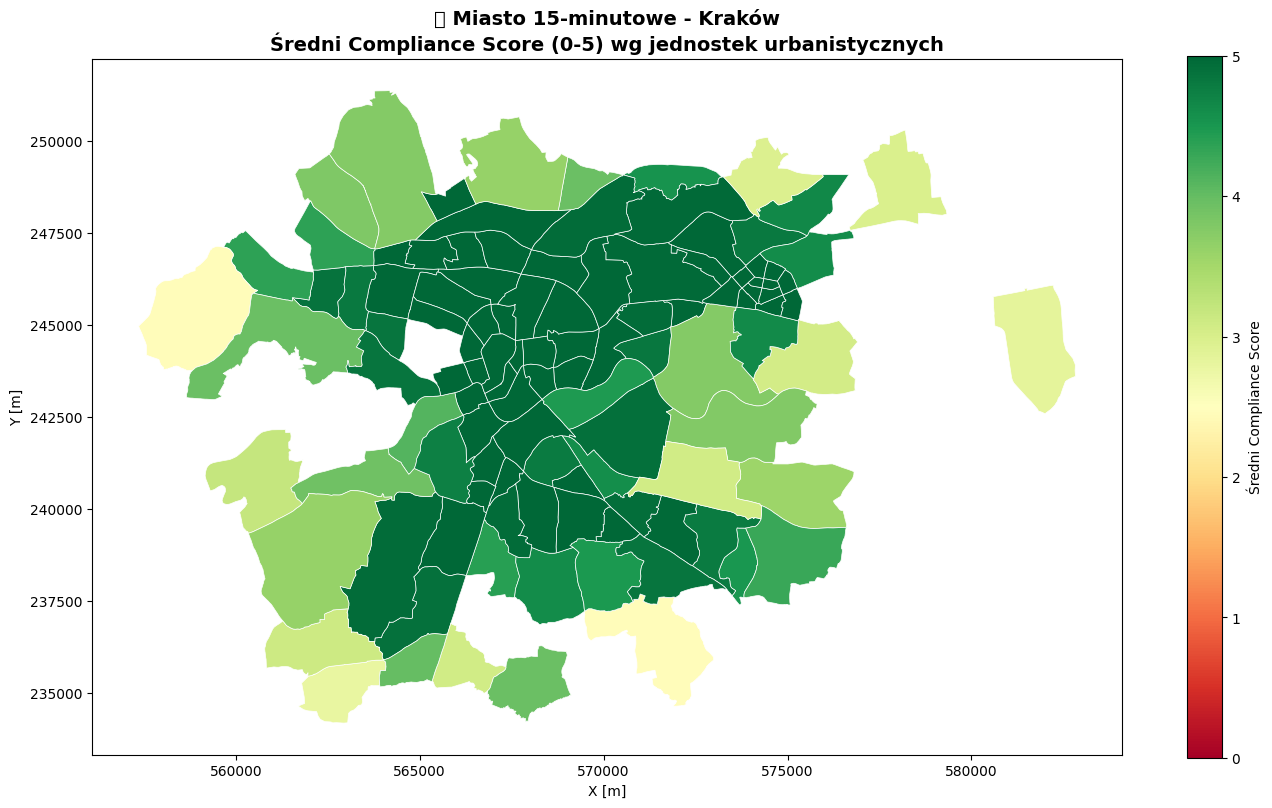

💾 Zapisano: data/mapa_jednostki_avg_score.png


In [8]:
# Druga mapa - średni score (0-5)
cmap_score = plt.cm.RdYlGn

fig, ax = plt.subplots(figsize=(14, 12))

units_results.plot(
    ax=ax,
    column='avg_score',
    cmap=cmap_score,
    vmin=0,
    vmax=5,
    edgecolor='white',
    linewidth=0.5,
    legend=True,
    legend_kwds={'label': 'Średni Compliance Score', 'shrink': 0.6}
)

ax.set_title(
    '🏙️ Miasto 15-minutowe - Kraków\n'
    'Średni Compliance Score (0-5) wg jednostek urbanistycznych',
    fontsize=14, fontweight='bold'
)

ax.set_aspect('equal')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')

plt.tight_layout()
plt.savefig('data/mapa_jednostki_avg_score.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Zapisano: data/mapa_jednostki_avg_score.png")

## 7. Eksport Wyników

In [9]:
# Eksport do GeoPackage
units_results.to_crs('EPSG:4326').to_file(
    'data/jednostki_15_min_wyniki.gpkg', 
    driver='GPKG', 
    layer='units_results'
)
print("💾 GeoPackage: data/jednostki_15_min_wyniki.gpkg")

# Eksport do CSV (bez geometrii)
csv_data = units_results.drop(columns=['geometry']).sort_values('full_coverage_pct', ascending=False)
csv_data.to_csv('data/jednostki_15_min_ranking.csv', index=False, encoding='utf-8-sig')
print("💾 CSV: data/jednostki_15_min_ranking.csv")

print("\n✅ ANALIZA ZAKOŃCZONA!")

💾 GeoPackage: data/jednostki_15_min_wyniki.gpkg
💾 CSV: data/jednostki_15_min_ranking.csv

✅ ANALIZA ZAKOŃCZONA!
